# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

<img src="https://image.freepik.com/free-vector/cartoon-delivery-man-brings-goods-customer-from-laptop-vector-illustration-concept-with-online-shopping-services_46527-344.jpg" />

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

## Problem Statement

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user satisfaction of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

## Executive Summary

The data is webscrapped from the Shopping category in Google Play Store and Apple Appstore, 8 apps reviews were chosen for this project (Amazon, Wish, ASOS, Lazada, Ebay, Shoppee, AliExpress, Carousell). The data used was exclusive dated in 2020 only as majority of the data scrapped are from in 2020. Data cleaning was done by removing stopwords, lemmatized and Vectorized to the raw data to create bag-of-words. 

There will be 2 steps to our modelling process, with the first step classifying whether the text is a good or bad review, followed by classifying the reviews into categories created through topic modelling to group them into different subgroups.

A few classification model were used, namely LogisticRegression, MultinomialNB, SGDClassifier, RandomForest, ADABoost. LogisticRegression give us the best results in classifying our data and thus used as the final model. 

As the data set is quite big, RandomizedSearch was used instead of Gridsearch to find the best hyperparameter.



### Content Summary
- Webscrapped reviews of 8 apps from Google Play Store & Apple App Store
- Data Cleaning 
  - Removing data not in year 2020
  - Removing emoji and punctuations
  - Removing non english words
  - Lemmatization
  - Compound score calculation using VaderSentiment
- EDA
- - Check for wrongly Rated reviews
  - Plotting distribution of features
  - Topic modelling of good reviews
  - Topic modelling of bad reviews
- Machine Learning Model 
  - LogisticRegression
  - MultinomialNB
  - SGDClassifier
  - RandomForest
  - ADABoost
- Deep Learning Model
  - Convolutional Neural Network
  
### Key Findings

- How do the app ratings differ across different shopping apps?
    - Users the wants to give a bad review will tend to just give a 1 rating
    - Users that wants to give a good review will tend to just give a 5 rating
    - Amazon seems to take the lead in having more bad reviews as compared to the other apps, especially App Issues , User interface and Account issues
    - Wish has slightly higher negative delivery issue reviews
    - AliExpress has High Refund issues. 
    - Shoppee takes the lead in Convenient app while ASOS takes the lead for User Interface
    - Bad reviews tend to have more word count as compared to Good reviews
    - More negative reviews are seen in 9am - 3pm period
    - More negative reviews on Tuesdays
    - Good Reviews are mostly on Convenient App and User Interface
    - Bad reviews are mostly on User Interface, App Issues and Purchase Experience
    - There is more negative reviews in 9am - 3pm period, and on Tuesdays
    - There is quite a number of reviews being 1 word, or otherwise rated wrongly by the user, (e.g. review: Excellent, Rating: 1)
- Is there any specific group of users we can look out for to improve the app?
    - The categories for Good Reviews are:  Convenient App, User Interface, Variety & Price, User Experience, Shopping Experience, Delivery, Consumer Satisfaction, In-App Actitives, Recommendations, Customer Service
    - The categories for Bad Reviews are:  Account Issues, Poor Seller Feedback, User Interface, Payment Issue, Poor Customer Service, Product Issue, App Issues, Delivery Issue, Refund, Product Listing Issues
- Are there any specific improvement we can work on to further improve user satisfaction of the app?
    - Ratings for Refund seems to take a dip in March
    - Ratings for Refund and Poor Seller Feedback is consistently low across the week.
    - Consumer Satisfaction is always going lower as compared to other topics in the good reviews sector
    - Customer Service and Consumer satisfaction is consistently lower in the week compared to other categories in good reviews
    - Delivery, Consumer Satisfaction and Recommendations are scored lower in good reviews.
    - Poor Seller feedback and refunds are scored lower in bad reviews
    - Base on compound scores, Delivery and Product tend to be very low as compared to other categories.
    - To summarise, it is important to look into customer satisfaction for the app, where Customer Service, Refund, Delivery and Recommendations are import factors to look out for. 
    - It is also important to put some focus on sellers that are doing bad on the platform.

### Metrics
Using the following metrics to evaluate the models:
- ROC AUC curve(for Binary Classification)
  -  The ROC AUC curve is able to tell how much the model is capable of distinguishing between 0 and 1, with 1 being perfectly classified.
- MCC Score
  - The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.
  
- f1 score weighted
  - The F1 Scores are calculated for each label and then their average is weighted by support - which is the number of true instances for each label. It can result in an F-score that is not between precision and recall

### Final Results
**Classification (Good & Bad Reviews)**
- LogisticRegression
  - Train data AUC: 0.966
  - Test data AUC: 0.965
  - MCC Score: 0.773
- Convolutional Neural Network
  - Train data AUC: 0.977
  - Test data AUC: 0.961
  - MCC Score: 0.767
  
**Multi Classification (Bad Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.731
    - Test Data f1 weighted score: 0.741	
    - MCC Score: 0.705	
- Convolutional Neural Network
  - Train data Acciracy: 0.914
  - Test data Accuracy: 0.717
  - MCC Score: 0.679

**Multi Classification (Good Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.868	
    - Test Data f1 weighted score: 0.878	
    - MCC Score: 0.851	
- Convolutional Neural Network
  - Train data Acciracy: 0.941
  - Test data Accuracy: 0.841
  - MCC Score: 0.805

**Model Remarks**
- From the misclassified post we can see the some comments are rated wrongly if we were to just look at the reviews directly.
- Some of the reviews are predicted wrongly. After looking at some of the reviews, it is clear that there are some misclassification by the topic modelling.
- It can be seen that the model is actually predicting better then what was classified in the first place.
- Some of the topics are very closely related to one another, which make it harder for the model to predict correctly
- Deep Learning Models are performing worst then Machine learning models, which could be due to the lack of complexity of the data for Neural Network to work well.

### Limitations
- The data set is mostly collected in the month of August and September, which means the model is able to predict this period better, but not in predicting past data. 
- More data could be collected, as there is a major lack of Apple Appstore reviews compared to Google Play Store

### Further research
- Try to use Compound score gathered from VaderSentiment to do the classification instead, as we know there is some misclassified post by users. which hopefully give us a better accuracy.
- Try different categories, not just shopping app category apps, do create a more complete review prediction model

### Content
1. Webscrap data
2. Data Cleaning
3. EDA
4. Model Part 1, Classification (Good & Bad Reviews)
5. Model Part 2, Multi Classification (Bad Review categories) 
6. Model Part 3, Multi Classification (Good Review categories)
7. Deep Learning Model

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

In [2]:
df = pd.read_csv('../data/reviews_Model.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,pos_score,compound_score,language,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.293,0.4404,en,9,3,20,26,47,8,Delivery
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.592,0.4404,en,9,3,20,13,19,3,Convenient App
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase thks,first happy,purchase experience purchase,NaN,NaN,...,0.286,0.3400,en,9,3,20,11,57,7,Consumer Satisfaction
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.285,0.4927,en,9,3,20,8,35,9,Variety & Price
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,0.000,0.0000,en,9,3,19,37,16,3,Delivery


## Taking out all bad reviews for training

In [4]:
df[df['rating'] <= 3 ]['category'].value_counts(normalize = True)

Account Issues            0.179483
App Issues                0.169551
User Interface            0.122759
Delivery Issues           0.122371
Refund                    0.099247
Poor Customer Service     0.093583
Product Issue             0.061845
Payment Issue             0.055094
Poor Seller Feedback      0.054163
Product Listing Issues    0.041903
Name: category, dtype: float64

In [5]:
df = df[df['rating'] <= 3 ][['category', 'clean_content', 'review']]
df.head()

,category,clean_content,review
10,Account Issues,stupid shoppee bubble game impossible tap bubb...,Stupid shoppee bubble game. Impossible. When t...
32,Delivery Issues,recent update shoppe bubble game unplayable li...,Recent update make shoppe bubble game unplayab...
58,Refund,ok d app come contact live chat rep sophie pur...,Was quite ok with d app until I came into cont...
106,Payment Issue,aware manage beat claim certain voucher able u...,Be aware that even though you managed to beat ...
118,Refund,delete app account receive defective item sell...,Deleted the app and my account. Received sever...


In [6]:
#Checking null values
df.isna().sum()

category         0
clean_content    0
review           0
dtype: int64

## Train Test Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['category'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['category'])

In [8]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 10309, X_test rows: 2578
y_train rows: 10309, y_test rows: 2578


## Baseline Model

In [9]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(10309, 5000)
(2578, 5000)


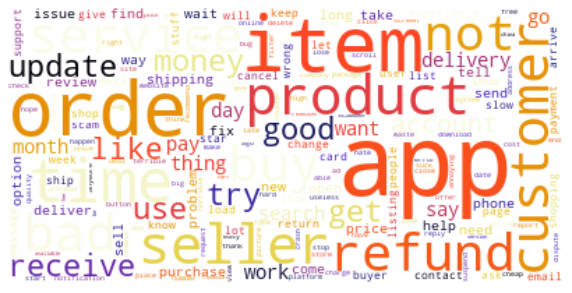

In [10]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.956445824037249
Accuracy score for Test data set: 0.7342901474010861


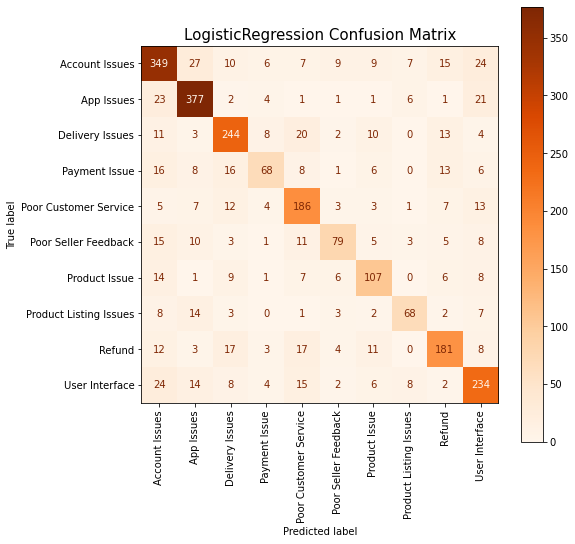

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(lr, test_data_features, y_test, ax = ax, cmap='Oranges', xticks_rotation=90);

In [13]:
print(classification_report(y_test, lr.predict(test_data_features), digits=3))

                        precision    recall  f1-score   support

        Account Issues      0.732     0.754     0.743       463
            App Issues      0.812     0.863     0.837       437
       Delivery Issues      0.753     0.775     0.764       315
         Payment Issue      0.687     0.479     0.564       142
 Poor Customer Service      0.681     0.772     0.724       241
  Poor Seller Feedback      0.718     0.564     0.632       140
         Product Issue      0.669     0.673     0.671       159
Product Listing Issues      0.731     0.630     0.677       108
                Refund      0.739     0.707     0.723       256
        User Interface      0.703     0.738     0.720       317

              accuracy                          0.734      2578
             macro avg      0.723     0.695     0.705      2578
          weighted avg      0.733     0.734     0.732      2578



## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [14]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = RandomizedSearchCV(cvec_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  114.507s


### TFIDVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=10000, min_df=3)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  135.458s


### HashingVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'hash__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = RandomizedSearchCV(hash_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=12000)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  191.899s


In [17]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'Kappa_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,Kappa_score,time(s)
0,LogisticRegression,CountVectorizer,0.698609,0.706462,0.663676,0.662387,115
1,LogisticRegression,TFIDVectorizer,0.714142,0.734124,0.696101,0.695271,135
2,LogisticRegression,HashingVectorizer,0.697499,0.713347,0.674039,0.673744,192


In [18]:
print(classification_report(y_test, gs_tfid_lr.predict(X_test), digits=3))

                        precision    recall  f1-score   support

        Account Issues      0.815     0.693     0.749       463
            App Issues      0.843     0.826     0.835       437
       Delivery Issues      0.779     0.737     0.757       315
         Payment Issue      0.618     0.627     0.622       142
 Poor Customer Service      0.728     0.776     0.751       241
  Poor Seller Feedback      0.459     0.686     0.550       140
         Product Issue      0.590     0.742     0.657       159
Product Listing Issues      0.891     0.528     0.663       108
                Refund      0.748     0.742     0.745       256
        User Interface      0.709     0.738     0.723       317

              accuracy                          0.731      2578
             macro avg      0.718     0.709     0.705      2578
          weighted avg      0.747     0.731     0.734      2578



## Trying with Different Models

### Logistic Regression

In [19]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(0, 10, 11))
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 50,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.7min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])
Fit time:  530.099s


### MultinomialNB

In [20]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': list(np.linspace(0,1,11))
}

gs_tfid_nb = RandomizedSearchCV(tfid_nb, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 50,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.3min finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.4))])
Fit time:  80.933s


### SGDClassifier

In [21]:
# Setting pipeline for two stages
tfid_clf = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('clf', SGDClassifier())
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__k_neighbors': [10, 15],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    
    
}

gs_tfid_clf = RandomizedSearchCV(tfid_clf, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 50,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_clf.fit(X_train, y_train)
tfid_clf_test_time = time() - t0
print(f'Best SGDClassifier Parameters: {gs_tfid_clf.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_clf_test_time);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


Best SGDClassifier Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=7000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('clf', SGDClassifier())])
Fit time:  104.620s


### RandomForest

In [22]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('rf', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__k_neighbors': [10, 15],
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [8, 15, 25],
    'rf__min_samples_split': [5, 15, 100],
    'rf__max_leaf_nodes': [10, None]
}

gs_tfid_ran = RandomizedSearchCV(tfid_ran, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 50,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.6min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=7000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=15, n_estimators=300,
                                        random_state=42))])
Fit time:  219.911s


### Adaboost

In [23]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [6000, 7000, 8000, 9000, 10000, 11000, 12000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2), (1,3)],
    'sampling__k_neighbors': [10, 15],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = RandomizedSearchCV(tfid_ada, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 30,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.9min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=7000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.3, n_estimators=200))])
Fit time:  491.340s


### Accuracy & F1 Macro Score

In [24]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])


summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SGDClassifier', 'TFIDVectorizer', 
                gs_tfid_clf.best_score_,
                gs_tfid_clf.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_clf.predict(X_test)),
                round(tfid_clf_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.731396,0.741864,0.705280,530
1,MultinomialNB,TFIDVectorizer,0.691889,0.708021,0.678070,81
2,SGDClassifier,TFIDVectorizer,0.700609,0.709072,0.669222,105
3,RandomForest,TFIDVectorizer,0.545768,0.550592,0.509382,220
4,Adaboost,TFIDVectorizer,0.454289,0.463632,0.380810,491


## Confusion Matrix

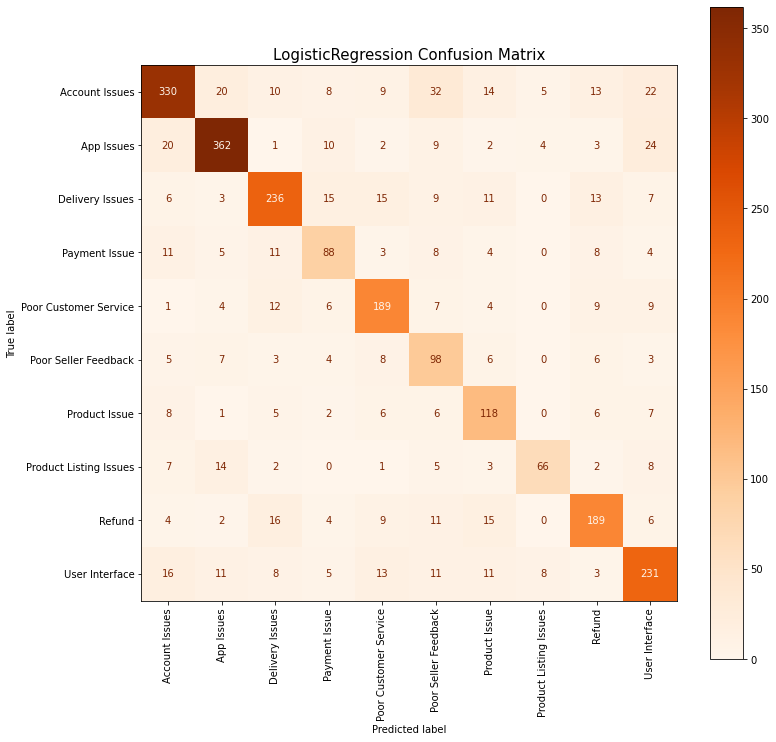

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges', xticks_rotation=90);

In [26]:
best_model_coef = pd.DataFrame(data = gs_tfid_lr.best_estimator_.named_steps['lr'].coef_, 
                               index = gs_tfid_lr.best_estimator_.named_steps['lr'].classes_,
                               columns = gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names()).T

best_model_coef

,Account Issues,App Issues,Delivery Issues,Payment Issue,Poor Customer Service,Poor Seller Feedback,Product Issue,Product Listing Issues,Refund,User Interface
10,0.352399,-0.009551,-0.248903,-0.271699,-0.100815,-0.005928,-0.068015,-0.028332,0.545067,-0.164221
10th,-0.056050,-0.086007,1.161951,-0.907634,-0.081501,-0.021894,-0.034269,0.018451,0.070197,-0.063242
10x,0.945198,-0.107919,-0.017756,-0.477055,-0.058216,-0.026703,-0.015456,0.391849,-0.373611,-0.260333
11th,-0.085342,-0.034962,0.991340,-0.142312,-0.532049,-0.048137,-0.181842,-0.011898,0.099557,-0.054356
18th,-0.072175,-0.032661,0.084016,-0.051649,-0.658718,-0.041033,1.130738,-0.013205,-0.317927,-0.027385
...,...,...,...,...,...,...,...,...,...,...
yr,3.395821,-1.154121,-0.998324,0.398531,0.684351,-0.454079,-0.564036,-0.342863,-0.554826,-0.410454
yung,-0.166362,-0.170850,-1.053383,-0.244005,2.213150,-0.585561,-1.048301,-0.138735,1.242290,-0.048243
zero,-0.179924,-0.131953,-0.884510,-0.098700,0.113401,-0.646686,1.121593,-0.239634,1.219422,-0.273009
zoom,-1.060305,-0.312131,-0.558016,-0.280482,-0.548673,-1.184065,-0.559525,5.202860,0.062876,-0.762538


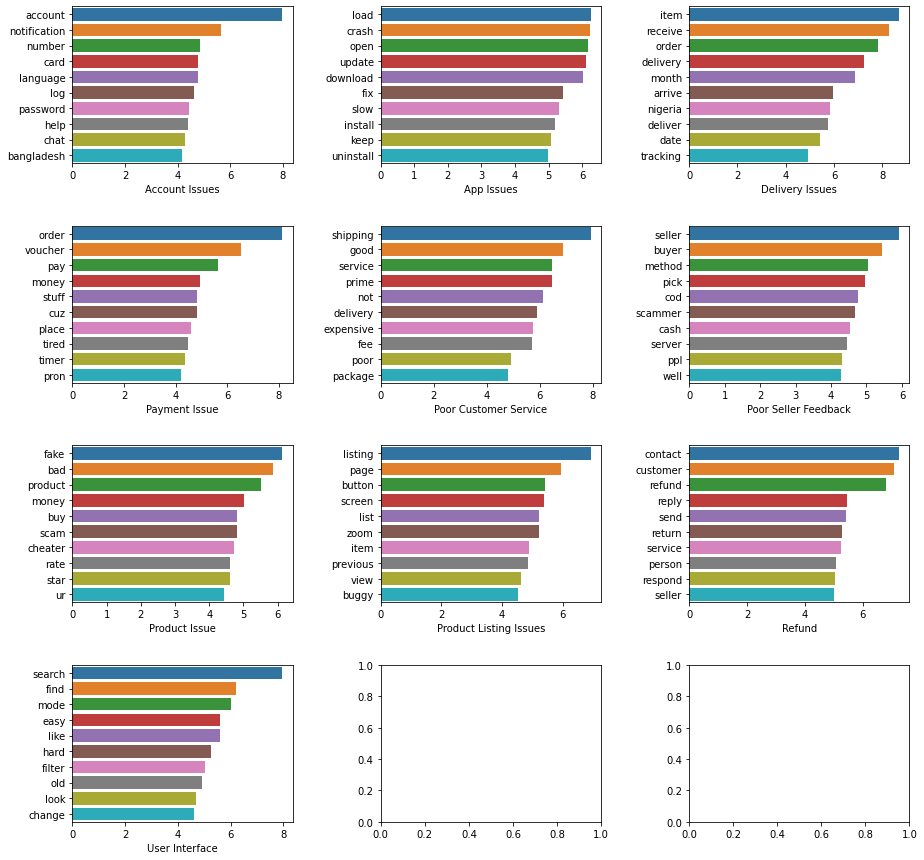

In [27]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (15,15))
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = ax.ravel()
for i in range(len(best_model_coef.columns)):
    sns.barplot(x = best_model_coef[best_model_coef.columns[i]].sort_values(ascending = False)[:10], 
                y = best_model_coef[best_model_coef.columns[i]].sort_values(ascending = False)[:10].index,
                ax = ax[i]);

## Checking Misclassified Post

In [28]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
39141,Refund,Delivery Issues,I love asos...but I think it's wrong that when...,love think wrong wrong item send happen time p...
10749,App Issues,Product Listing Issues,Keep going back to previous page on its own ve...,go previous page irritating use nowadays.was w...
9780,Refund,Product Issue,Money grabbing policy will make this app usele...,money grab policy app useless soon seller caus...
23594,Account Issues,Poor Seller Feedback,So so difficult to fill in address and postal ...,difficult fill address postal code impossible ...
36522,User Interface,Account Issues,Freezes whenever I try to change my payment op...,freeze try change payment option shipping deta...
1944,Refund,Payment Issue,Not professional enough n very upset with prod...,professional n upset product deliver initiativ...
55260,User Interface,Product Issue,Generally good promo but bank promo always ful...,generally good promo bank promo fully redeem s...
37856,Product Listing Issues,User Interface,What is going on Amazon? Anything I search for...,go search bring page result option page check ...
32160,App Issues,User Interface,Unable to log in or use the app at all with my...,unable log use app vpn enable samsung galaxy s...
10778,User Interface,Account Issues,waste of time it won't show you what you want ...,waste time will want miss old olx aps


### Comments
- Some of the reviews are predicted wrongly. After looking at some of the reviews, it is clear that there are some misclassification by the topic modelling.
- It can be seen that the model is actually predicting better then what was classified in the first place.


## Train data on whole dataset

In [29]:
best_model = gs_tfid_lr.best_estimator_
best_model

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [30]:
best_model.fit(df['clean_content'], df['category'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [31]:
filename = 'Best_Model_BadReview_P2.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))